Uses dgl==0.6.1

In [1]:
import pandas as pd
import numpy as np
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import faiss
import torch
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
dataset = DglNodePropPredDataset(name='ogbn-arxiv', 
                                 root='../../data/dataset_dgl/')

In [3]:
graph = dataset[0][0]

In [4]:
graph

Graph(num_nodes=169343, num_edges=1166243,
      ndata_schemes={'year': Scheme(shape=(1,), dtype=torch.int64), 'feat': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={})

In [5]:
graph.nodes()

tensor([     0,      1,      2,  ..., 169340, 169341, 169342])

In [6]:
output_emb_file = '../../ckpts/TransE_l1_ogbn-arxiv_4/ogbn-arxiv_TransE_l1_entity.npy'
output_rel_file = '../../ckpts/TransE_l1_ogbn-arxiv_4/ogbn-arxiv_TransE_l1_relation.npy'

In [7]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 500)

In [8]:
relations = np.load(output_rel_file)
relations.shape

(1, 500)

In [9]:
relations

array([[ 1.59926936e-02,  7.07014091e-03,  7.95916468e-03,
        -5.79212140e-03,  2.31727269e-02, -2.46994514e-02,
        -2.07549036e-02,  5.94592141e-03, -1.32617168e-02,
        -3.46630323e-03, -7.42688030e-03, -2.24086316e-03,
        -6.51060641e-02, -3.26835886e-02,  2.51326542e-02,
         5.65626891e-03, -1.48245716e-03,  1.49890920e-02,
         4.59463857e-02, -1.94064882e-02, -2.69832425e-02,
         1.57120656e-02,  8.93786433e-04,  2.61690114e-02,
        -1.34911099e-02, -1.25655215e-02,  2.90469732e-02,
         2.57836469e-03,  1.48117431e-02,  1.72464214e-02,
         1.73698179e-02, -3.27217422e-04, -1.87590178e-02,
        -1.19621716e-02,  9.51813255e-03,  3.08054849e-03,
         8.12240224e-03,  1.44396638e-02, -5.12105739e-03,
        -4.18962725e-03,  3.02430000e-02,  9.24817566e-03,
        -4.12553782e-03, -2.08604354e-02,  9.67998803e-03,
        -2.73146108e-02,  3.35288495e-02, -1.36510395e-02,
         1.98725555e-02, -2.56399885e-02,  4.28762883e-0

In [10]:
np.linalg.norm(relations, axis=1)

array([0.44327468], dtype=float32)

## L2 Distance

In [11]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [12]:
index.train(embeddings)
index.add(embeddings)

In [13]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f420d3bcea0> >

In [14]:
index.ntotal

169343

## Check if there is a neighbor in the n closest embeddings

In [15]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [16]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [17]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

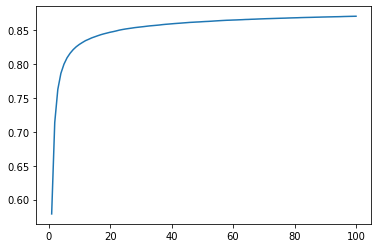

In [18]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]
label_dict = {idx: val for idx, val in enumerate(y.numpy())}
label_transform = np.vectorize(label_dict.get)

In [20]:
ind_labels = label_transform(indices)

In [21]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [22]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [23]:
perc_same_class = n_same_class / n_total

In [24]:
perc_same_class

array([0.63521374, 0.57414833, 0.52582038, 0.48823394, 0.45912261,
       0.43566706, 0.41662189, 0.40067791, 0.38739258, 0.37585374,
       0.36587281, 0.35719418, 0.34955455, 0.34272495, 0.33659575,
       0.33100534, 0.32596877, 0.32131926, 0.31699009, 0.31313783,
       0.3095501 , 0.30618653, 0.30303842, 0.3001497 , 0.29744011,
       0.29491351, 0.29250802, 0.29021466, 0.28800922, 0.28597068,
       0.28402957, 0.28215811, 0.28033242, 0.27864018, 0.27703351,
       0.27545196, 0.27394201, 0.27250843, 0.27111717, 0.26980832,
       0.26851362, 0.26729492, 0.26614334, 0.26501579, 0.26394504,
       0.26291211, 0.2618989 , 0.26092937, 0.25999147, 0.25905411,
       0.25815154, 0.2573055 , 0.25646653, 0.2556442 , 0.25483942,
       0.25407067, 0.25332547, 0.25259212, 0.25186381, 0.2511769 ,
       0.25052675, 0.24988671, 0.24924777, 0.2486348 , 0.24803678,
       0.2474431 , 0.24687182, 0.24628148, 0.24570328, 0.24514371,
       0.24459608, 0.24409277, 0.24357972, 0.24308476, 0.24258

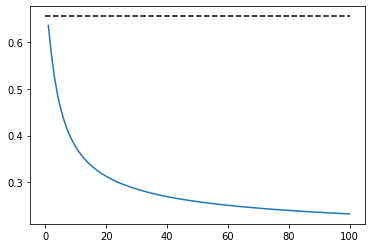

In [25]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Check if there is a neighbor in the n closest embeddings + relation

In [26]:
embeddings

array([[ 0.00083917, -0.04448659, -0.02397577, ...,  0.00399606,
         0.01898491,  0.00513803],
       [-0.03064783,  0.03865696, -0.038293  , ...,  0.02053928,
         0.0524037 ,  0.03459967],
       [-0.03446627, -0.01005348, -0.01027914, ...,  0.01632214,
         0.0298595 , -0.00473491],
       ...,
       [-0.03247669,  0.0384473 , -0.01028039, ..., -0.0245166 ,
        -0.00737912,  0.01988413],
       [ 0.02763515, -0.038565  , -0.01396578, ...,  0.0147399 ,
         0.01845346,  0.02694579],
       [ 0.03163235, -0.00168205, -0.01453425, ...,  0.04850214,
        -0.04310707, -0.04463039]], dtype=float32)

In [27]:
embeddings + relations

array([[ 0.01683186, -0.03741644, -0.0160166 , ...,  0.01615204,
        -0.01047551, -0.01460188],
       [-0.01465513,  0.0457271 , -0.03033384, ...,  0.03269526,
         0.02294328,  0.01485975],
       [-0.01847357, -0.00298334, -0.00231998, ...,  0.02847812,
         0.00039908, -0.02447482],
       ...,
       [-0.016484  ,  0.04551744, -0.00232122, ..., -0.01236062,
        -0.03683953,  0.00014422],
       [ 0.04362784, -0.03149486, -0.00600661, ...,  0.02689588,
        -0.01100696,  0.00720588],
       [ 0.04762504,  0.00538809, -0.00657509, ...,  0.06065812,
        -0.07256749, -0.0643703 ]], dtype=float32)

In [28]:
max_k = 100
distances, indices = index.search(embeddings + relations, max_k + 1)

In [29]:
distances

array([[0.19649267, 0.4849789 , 0.51443565, ..., 0.7699493 , 0.7722385 ,
        0.77474946],
       [0.19649243, 0.7319534 , 0.84921956, ..., 0.96357524, 0.96393335,
        0.96402645],
       [0.1964925 , 0.60713965, 0.6250204 , ..., 0.7107393 , 0.7107926 ,
        0.7108798 ],
       ...,
       [0.19649255, 0.6028824 , 0.6335739 , ..., 0.7125001 , 0.7125671 ,
        0.712608  ],
       [0.19649237, 0.5888735 , 0.6025243 , ..., 0.7102303 , 0.7104757 ,
        0.71057665],
       [0.19649243, 0.63275075, 0.7168182 , ..., 0.87582886, 0.8762356 ,
        0.8762857 ]], dtype=float32)

In [30]:
indices

array([[     0,  61100,  92115, ...,  73443,  86354, 122496],
       [     1, 141692, 154949, ...,   2119,  45162,   2700],
       [     2, 134600,  20073, ..., 168450,  70455,  70166],
       ...,
       [169340,  12746, 132029, ...,  66751, 110641, 103756],
       [169341,  61100, 130136, ...,  22596, 144665, 152777],
       [169342, 158981,  27824, ..., 135993,  81565, 119218]])

In [31]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [32]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

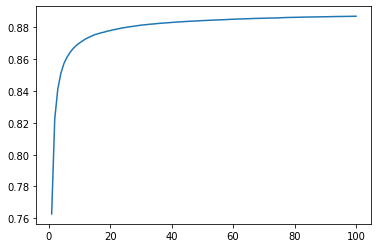

In [33]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

### Percentage of same class neighbors by neighborhood size

In [34]:
y = dataset[0][1][:, 0]
label_dict = {idx: val for idx, val in enumerate(y.numpy())}
label_transform = np.vectorize(label_dict.get)

In [35]:
ind_labels = label_transform(indices)

In [36]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [37]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [38]:
perc_same_class = n_same_class / n_total

In [39]:
perc_same_class

array([0.55672216, 0.50014172, 0.45673574, 0.4239133 , 0.39876464,
       0.37852662, 0.36226138, 0.34865849, 0.33718744, 0.32744548,
       0.31896157, 0.31149255, 0.30476243, 0.2988533 , 0.29346238,
       0.28855193, 0.28410664, 0.28010803, 0.27651913, 0.27306325,
       0.26991907, 0.26701321, 0.26434643, 0.26179386, 0.2593796 ,
       0.25713061, 0.25502481, 0.25301206, 0.25111918, 0.24932888,
       0.24766665, 0.24603375, 0.24451485, 0.24309103, 0.24168109,
       0.24034799, 0.23907579, 0.23781988, 0.23665215, 0.23551431,
       0.23439165, 0.23335085, 0.23232605, 0.23134891, 0.23040364,
       0.22952105, 0.2286348 , 0.22778855, 0.2269778 , 0.22621059,
       0.22546663, 0.2247288 , 0.22403687, 0.22334661, 0.22266395,
       0.2220391 , 0.22138883, 0.22077361, 0.22015362, 0.21953835,
       0.2189542 , 0.21838917, 0.21783955, 0.21730452, 0.21677987,
       0.21626987, 0.21575975, 0.21527097, 0.21479731, 0.21432823,
       0.21388867, 0.21343155, 0.2129952 , 0.21257791, 0.21214

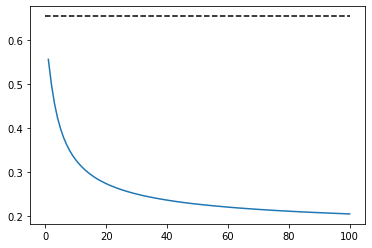

In [40]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [41]:
pca = PCA(n_components=2)

In [42]:
pca.fit(embeddings)

PCA(n_components=2)

In [43]:
emb_2d = pca.transform(embeddings)

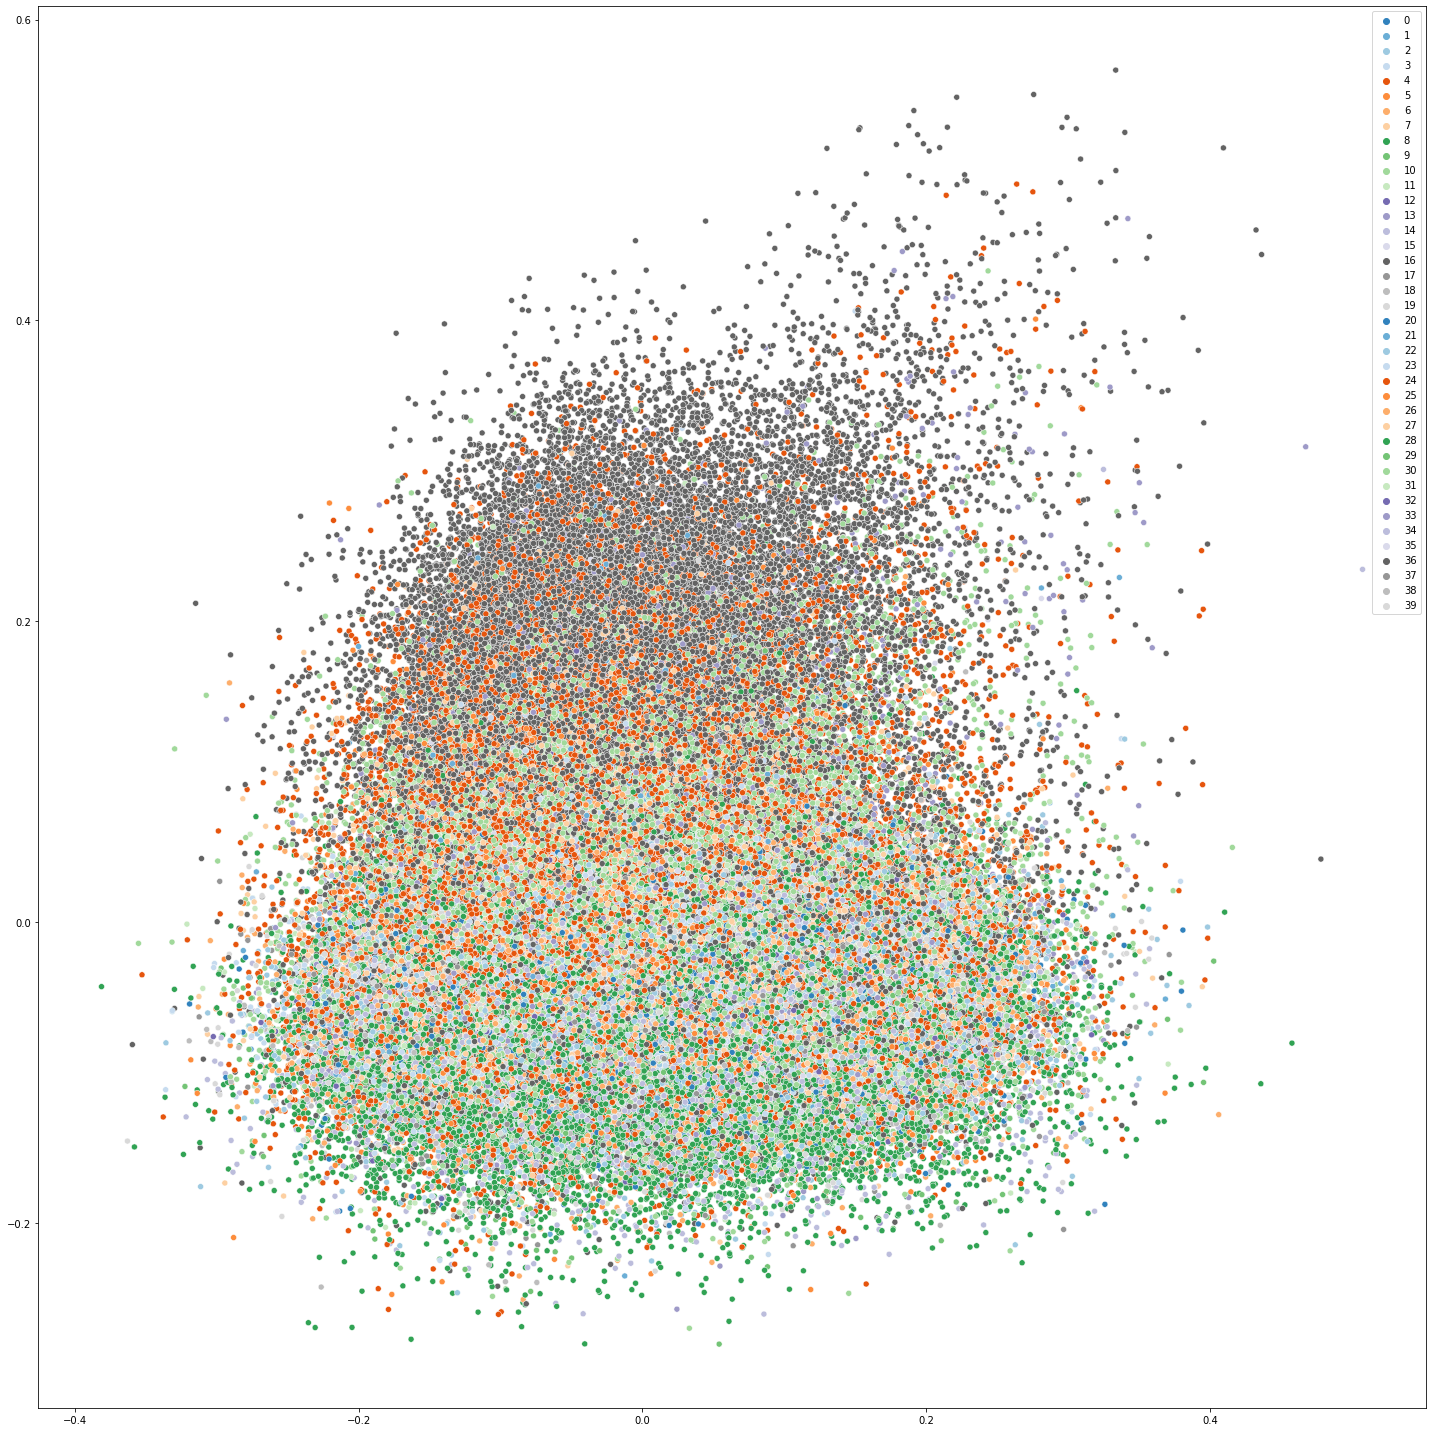

In [44]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [45]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

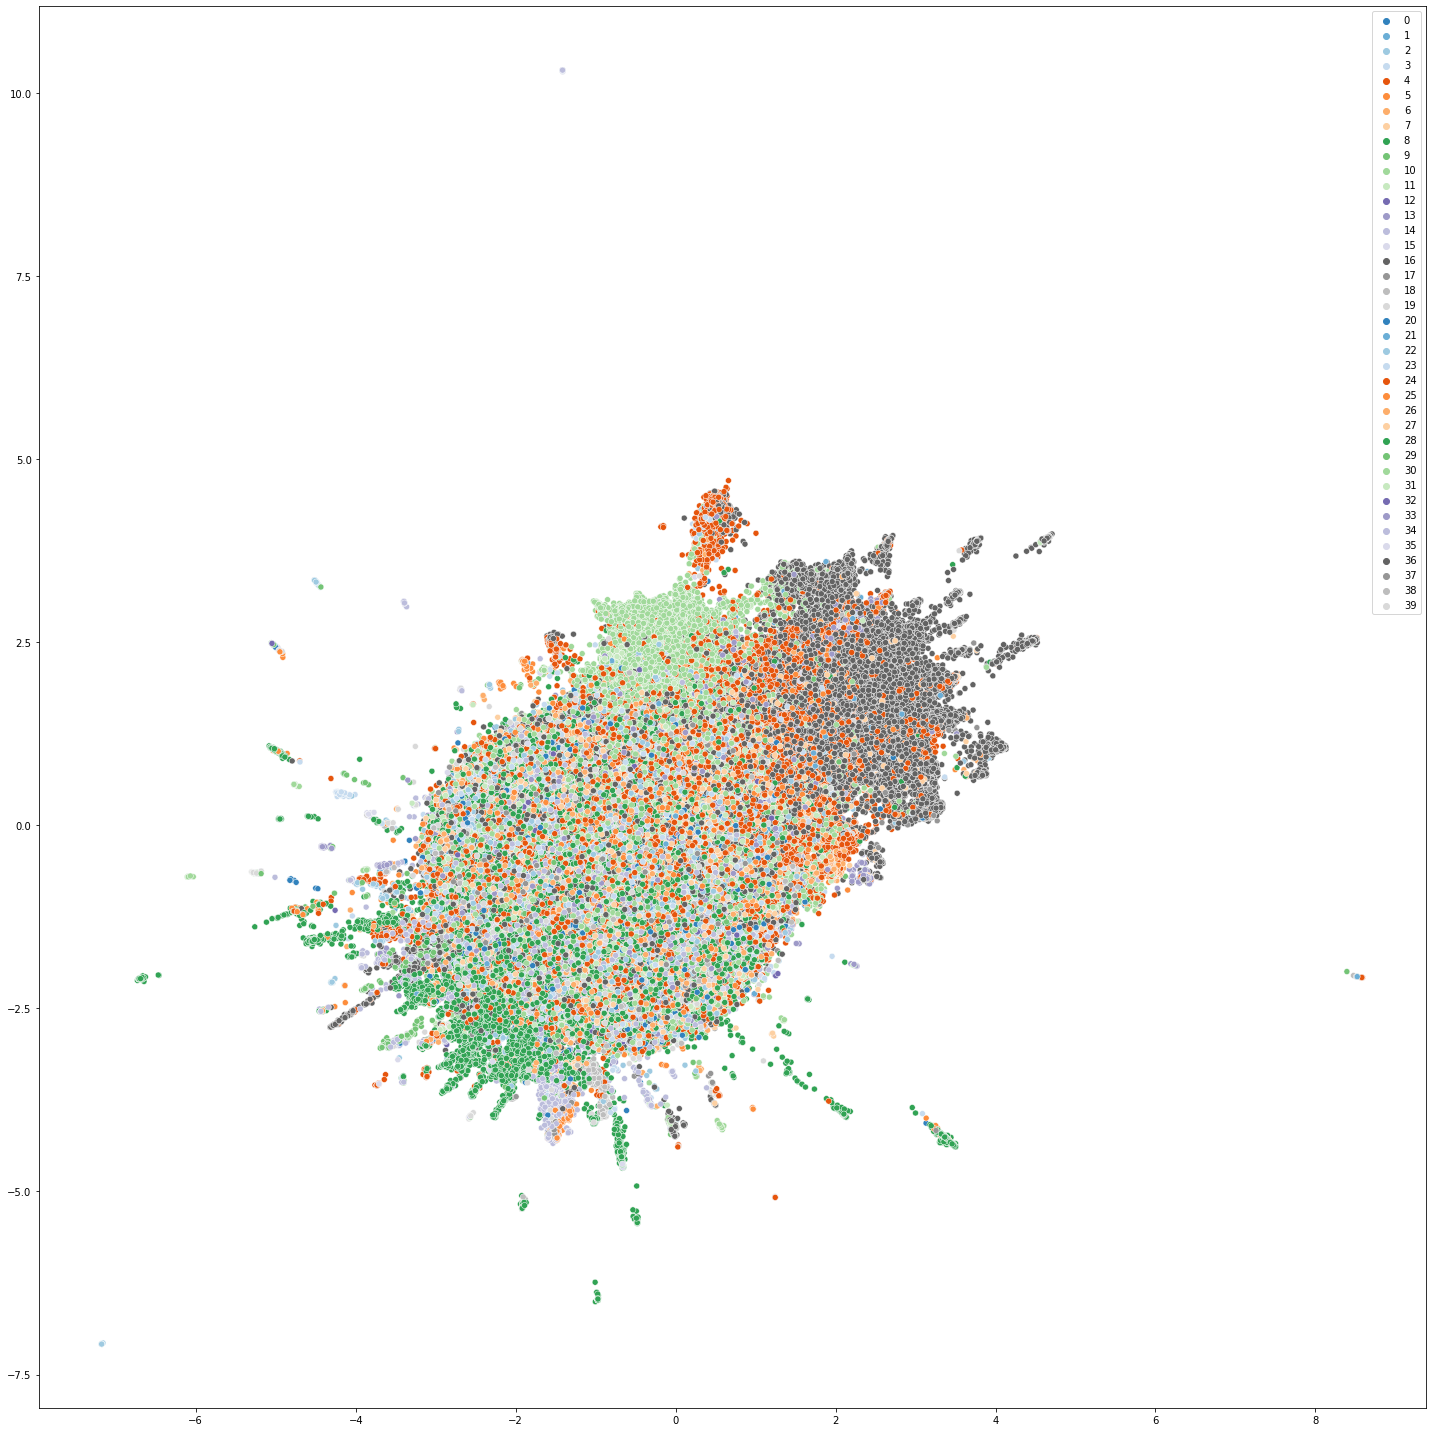

In [46]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()